## Template based decoding

* compute the mean response (response template) per category

* decode the nearest template for each response (over n-1 trials by excluding current trial from template)

* confusion matrix

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import confusion
from confusion import generate_confusion_matrix
from data_loader import SessionDataLoader
from spikeplot import raster
from spikes.filters import gaussian_filter, exp_filter
from spikes.binning import bin_spikes
from template_decoding import (
        compute_distances_to_templates,
        compute_templates,
        decode,
        prepare,
        template_selectors,
        get_plotty_lines,
)

%load_ext autoreload
%autoreload 2

In [2]:
data_loader = SessionDataLoader("GreBlu9508M", 2)

In [3]:
table = data_loader.load_table()

In [4]:
table = table[table["call_type"] != "None"]
table = table.copy()

In [5]:
t_arr, spikes = bin_spikes(table["spike_times"], min_time=0.0, max_time=0.6)
spikes_filtered = exp_filter(spikes, 5.0)

table["binned_spikes"] = spikes.tolist()
table["psth"] = spikes_filtered.tolist()

In [85]:
unit_table = table[table["unit"] == (21, 1)]
unit_table = unit_table.copy()

## Stimulus Decoding

First: Prepare the unit data by sorting it by call type and setting the index to be the
category being decoded.

In [86]:
# NEED TO DO THIS FIRST...
unit_table = prepare(unit_table, "stim")

if False:
    # For shuffling poirpises
    unit_table["psth"] = unit_table["psth"].sample(frac=1).tolist()

Next, compute the selectors (boolean arrays) for each template that will be generated. This automatically excludes the row itself from the template calculation and also ensure every template is generated by averaging the same number of samples.

In [87]:
selectors, categories = template_selectors(unit_table, "stim")

(Just visualizing one of the templates)

In [88]:
sample_n = 8
templates = compute_templates(unit_table, selectors[0], "psth", sample_n=sample_n)

In [89]:
plot_cat = "110"
plot_cat_idx = np.where(categories == plot_cat)[0][0]

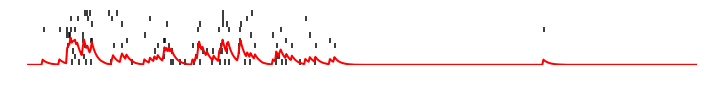

In [90]:
plt.figure(figsize=(12, 1))
raster.plot(unit_table[unit_table["stim"] == plot_cat]["spike_times"], 0, 0.6)
scale = plt.ylim()[1] / 2.0
plt.plot(
    t_arr,
    scale * templates[plot_cat_idx] / np.max(templates[plot_cat_idx]),
    color="red",
    linewidth=2)
plt.axis("off")
plt.show()

Next: Compute distances of each trial to each template

In [91]:
distances = compute_distances_to_templates(unit_table, selectors, "psth")

Finally, choose the best category for each data point, compute mutual information and decoding accuracy.

In [92]:
predicted = decode(unit_table, distances, categories)
actual = unit_table.index

conf = generate_confusion_matrix(actual, predicted, categories, joint=True)

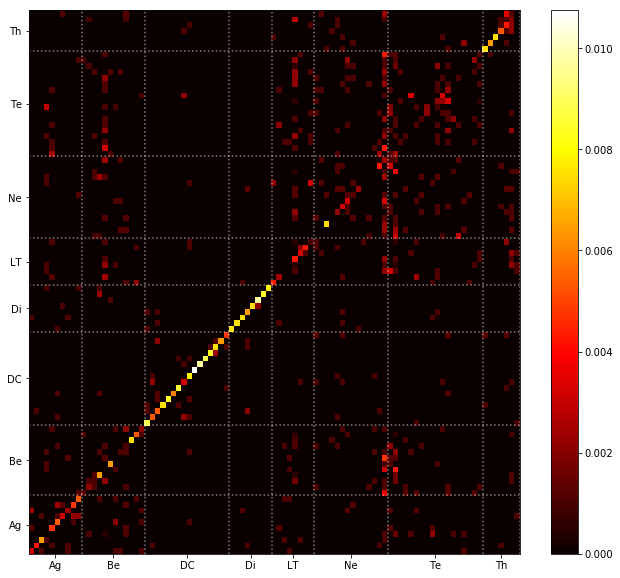

Mutual Information: 4.01 bits
Accuracy: 35.30%


In [93]:
barriers, labels, label_posititions = get_plotty_lines(unit_table)
plt.figure(figsize=(11, 10))
plt.pcolormesh(conf, vmin=0.0, vmax=1.0, cmap="hot")
plt.hlines(barriers, 0, barriers[-1], color="white", linestyles=":", alpha=0.5)
plt.vlines(barriers, 0, barriers[-1], color="white", linestyles=":", alpha=0.5)
plt.xticks(label_posititions, labels)
plt.yticks(label_posititions, labels)
plt.colorbar()
plt.show()
print "Mutual Information: {:.2f} bits".format(confusion.mutual_information(conf))
print "Accuracy: {:.2f}%".format(confusion.accuracy(conf) * 100)

## Call Type Decoding

In [94]:
unit_table = prepare(unit_table, "call_type")

In [95]:
selectors, categories = template_selectors(unit_table, "call_type")

In [96]:
distances = compute_distances_to_templates(unit_table, selectors, "psth")

In [97]:
predicted = decode(unit_table, distances, categories)
actual = unit_table.index

conf = generate_confusion_matrix(actual, predicted, categories, joint=False)

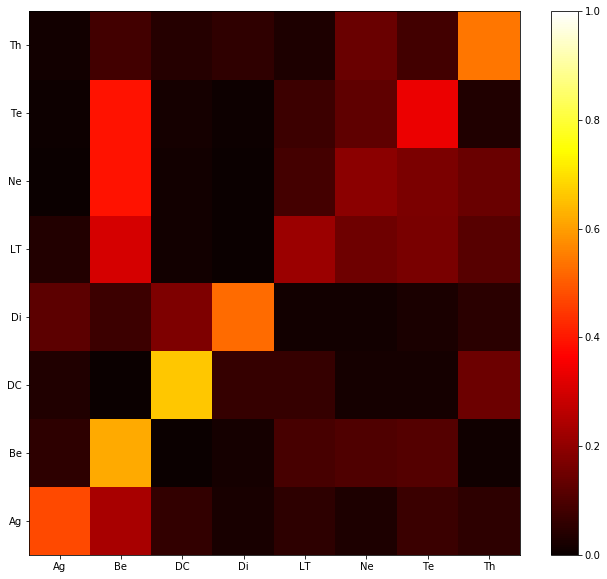

Mutual Information: 0.79 bits
Accuracy: 44.60%


In [98]:
_, labels, _ = get_plotty_lines(unit_table)
plt.figure(figsize=(11, 10))
plt.pcolormesh(conf, vmin=0.0, vmax=1.0, cmap="hot")
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels)
plt.colorbar()
plt.show()
print "Mutual Information: {:.2f} bits".format(confusion.mutual_information(conf))
print "Accuracy: {:.2f}%".format(confusion.accuracy(conf) * 100)